In [1]:
import sys
sys.path.append('..')
from networks.siamese.omniglot import Omniglot
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# from datasets import Loader

In [10]:
tf.reset_default_graph()
nn = Omniglot(shape=(105,105))
nn.forward_prop()
nn.compute_cost(mode='l2_on')
nn.optimize('Momentum')
nn.accuracy()
print(nn)

Twin_1_dist_layer:Tensor("Sigmoid:0", shape=(4096, ?), dtype=float32)
Twin_2_dist_layer:Tensor("Sigmoid_1:0", shape=(4096, ?), dtype=float32)
logits:Tensor("Add_10:0", shape=(1, ?), dtype=float32)
cost:Tensor("Mean:0", shape=(), dtype=float32)
optimizer:[<tf.Operation 'Momentum' type=NoOp>, <tf.Operation 'Momentum_1' type=NoOp>, <tf.Operation 'Momentum_2' type=NoOp>, <tf.Operation 'Momentum_3' type=NoOp>, <tf.Operation 'Momentum_4' type=NoOp>, <tf.Operation 'Momentum_5' type=NoOp>]
accuracy:Tensor("Mean_1:0", shape=(), dtype=float32)


In [2]:
orl = Loader(n_examples=10,mode="orl_split",path='/Users/mehmetbezcioglu/Documents/SEMESTER1/ThirdYearProject',normalise=True)

# Re-arrange the ORL dataset
Re-arrange from: 
<b>(40,10,105,105,1)</b> to:

-  (30,2,105,105,1) = `train_set`
-  (30,8,105,105,1) = `validation_set`
-  (10,10,105,105,1) = `one_shot_set`

In [5]:
# orl.X = orl.X.reshape(-1,105*105)
print(orl.X.shape)
print(orl.X_validation.shape)
print(orl.one_shot_set.shape)

(30, 8, 105, 105, 1)
(30, 2, 105, 105, 1)
(10, 10, 105, 105, 1)


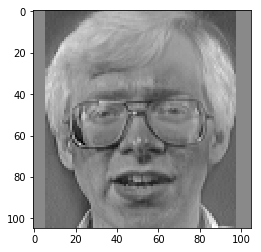

In [9]:
plt.imshow(orl.one_shot_set[1,0].reshape(105,105),cmap='gray')
plt.show()

In [13]:
def generateOneShotTrials(X,size):
    '''
    Generates one shot trial for the data given where one one-shot trial is comparing one image against n-images.
    Therefore, comparing 20 different images against 20 images is 20 one-shot trials of each trial being 20-way.

    Arguments:
    data -- shape = (n_chars, n_drawers, 105, 105, 1)

    Returns:
    trainImgs -- shape  (20,105,105,1)
    testImgs -- shape (20,105,105,1)
    labels -- shape(1,20)
    '''
    chars = np.random.randint(low= 0,high= X.shape[0],size=size)
    drawers = np.random.randint(low=0 ,high=X[chars].shape[1],size=2) if X.shape[1] > 2 else np.random.permutation(2)
    testImgs = X[chars,drawers[0]]
    trainImgs = X[chars,drawers[1]]
    labels = chars
    return (testImgs,trainImgs,labels.reshape(1,size))

In [20]:
# test_imgs, train_imgs, labels = generateOneShotTrials(orl.X_validation,size=10)          
test_imgs, train_imgs, labels = generateOneShotTrials(orl.one_shot_set,size=10)  
test_imgs.shape
# labels.shape

(10, 105, 105, 1)

In [39]:
import os
import cv2

class Loader(object):
    file_number = 0
    def __init__(self,n_examples,mode,path='/Users/mehmetbezcioglu/Downloads/images_background',normalise=False):
        self.X = []
        self.paths = []
        if mode == "train_split":
            self.X_validation = [] 
        if mode == "orl_split":
            self.X_validation = [] 
            self.one_shot_set = []
            self.one_shot_directories = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10']
        append_one_shot_set = False
        for subdirectory,_,files in os.walk(path):
            if subdirectory.split('/')[-1] in self.one_shot_directories:
                append_one_shot_set = True
            for file in files:
                if ".png" in file or ".pgm" in file:
                    if append_one_shot_set:
                        self.one_shot_set.append(self.import_and_resize_image(os.path.join(subdirectory,file)))
                        continue

                    if ((mode == "train_split") and (("_19" in file) or ("_20" in file))):
                            self.X_validation.append(self.import_and_resize_image(os.path.join(subdirectory,file)))
                            continue
                    if ((mode == "orl_split") and (("9" in file) or ("10" in file))):
                            self.X_validation.append(self.import_and_resize_image(os.path.join(subdirectory,file)))
                            continue
                    if int(file.split('_')[-1].split('.')[0]) <= n_examples:
                        self.X.append(self.import_and_resize_image(os.path.join(subdirectory,file)))
                        self.paths.append(os.path.join(subdirectory,file))
            append_one_shot_set = False

        self.X = self._normalise(self.X,n_examples = n_examples-2,normalise= normalise) if mode == "train_split" or mode == "orl_split" else self._normalise(self.X,n_examples = n_examples,normalise= normalise)
        self.X_validation = self._normalise(self.X_validation,n_examples = 2,normalise= normalise) if mode == "train_split" or mode == "orl_split"  else None
        self.one_shot_set = self._normalise(self.one_shot_set,n_examples = len(self.one_shot_directories) , normalise = normalise) if mode == "orl_split" else None


    @staticmethod
    def _normalise(X,n_examples,normalise):
        remainder = len(X) % n_examples
        if remainder:
            X = np.asarray(X)[:-remainder]
        else:
            X = np.asarray(X)
        # print(X.shape)
        X = X.reshape(-1,n_examples,X.shape[1],X.shape[2],1)	
        if normalise:
            X = X.reshape(-1,105*105)
            mu = np.mean(X,axis=0).reshape(1,11025)
            std = np.std(X,axis=0).reshape(1,11025)
            X = np.subtract(X,mu)
            X /= (std + 1e-100)
            X = X.reshape(-1,n_examples,105,105,1)
            # X = X / 255.
        return X


    def generateOneShotTrials(self,X,size):
        '''
        Generates one shot trial for the data given where one one-shot trial is comparing one image against n-images.
        Therefore, comparing 'size' number of different images against 'size' images is 'size' one-shot trials of each trial being 'size'-way.

        Arguments:
            data -- shape = (n_chars, n_drawers, 105, 105, 1)

        Returns:
            trainImgs -- shape  (size,105,105,1)
            testImgs -- shape (size,105,105,1)
            labels -- shape(1,size)
        '''
        # print("in function")
        chars = np.random.randint(low= 0,high= X.shape[0],size=size)
        # print()
        # print("Characters drawn:{}".format(chars))
        # print("X[chars].shape: {}".format(X[chars].shape))
        drawers = np.random.randint(low=0 ,high=X[chars].shape[1],size=2) if X.shape[1] > 2 else np.random.permutation(2)
        # print("Drawers drawn:{}".format(drawers))
        testImgs = X[chars,drawers[0]]
        trainImgs = X[chars,drawers[1]]
    #     trainImgs = 
        # print(testImgs.shape)
        # print(trainImgs.shape)
        labels = chars
    #     plt.imshow(testImgs[0].reshape(105,105),cmap='gray')
    #     plt.show()
    #     plt.imshow(testImgs[1].reshape(105,105),cmap='gray')
    #     plt.show()
    #     plt.imshow(trainImgs[0].reshape(105,105),cmap='gray')
    #     plt.show()
    #     plt.imshow(trainImgs[1].reshape(105,105),cmap='gray')
    #     plt.show()

        return (testImgs,trainImgs,labels.reshape(1,size))




    def get_one_batch(self,batch_size,drawer_size,seed):
        """
        Generates training batches of batch_size where each element in the batch is a pair.
        This function generates random indexes between 0 and number of characters in the dataset.
        It also randomly generates two numbers corresponding to the drawers selected to pick the corresponding
        images in the data. 
        Lastly, it generates a second character indices vector to select different characters in the data.

        The first half of the X1 and X2 is labelled as 'SAME' class denoted by 0 in the labels variable.
        The second half is labelled as 'DIFFERENT' class denoted by 1 in the labels variable.

        Arguments:
            - batch_size: integer specifing the batch length
            - drawer_size: integer specifying the number of drawer to pick for each character

        Returns:
            - training batch first pair X1
                - shape: (batch_size,105,105,1)
                - type: numpy array
            - training batch first pair X2 
                - shape: (batch_size,105,105,1)
                - type: numpy array
            - training labels 
                - shape: (1,batch_size)
                - type : numpy array
        """
        np.random.seed(seed)
        _chars = np.random.randint(0,self.X_validation.shape[0],size=batch_size)
        # print("Randomly chosen character indices in the dataset:{}".format(_chars))
        _drawers = np.random.randint(0,self.X_validation.shape[1],size=drawer_size) if self.X_validation.shape[1] > 2 else np.random.permutation(2)
        # print("Randomly chosen drawer indices for each chosen character:{}".format(_drawers))


        X1 = np.asarray(self.X_validation[_chars,_drawers[0]])
        X2 = np.asarray(self.X_validation[_chars[:batch_size//2],_drawers[1]])
#         print(X1.shape)
        # select the second char indices for 'DIFFERENT' chars
        _chars_ = (np.random.randint(0,self.X_validation.shape[0],size=batch_size//2) + _chars[batch_size//2:])% self.X_validation.shape[0]
        # print("Second chosen characters indices in the dataset:{}".format(_chars_))
        X2 = np.concatenate((X2,np.asarray(self.X_validation[_chars_,_drawers[0]])),axis=0)
        # print(X1.shape)
        # print(X2.shape)

        labels = np.concatenate((np.zeros([1,batch_size//2]),np.ones([1,batch_size//2])),axis=1)
        # print(labels)
        return (X1,X2,labels)


    def get_training_pairs(self,batch_size,drawer_size,seed):
        m = self.X_validation.shape[0] * self.X_validation.shape[1]
        iters = m // batch_size
        assert iters != 0, "Batch size should be less than the number of examples."
        batch = []
        for i in range(iters):
            seed += 1
            batch.append(self.get_one_batch(batch_size,drawer_size,seed))
        return batch


    def import_and_resize_image(self,path):
        # print(path)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        # print('image shape:{}'.format(img.shape))
        # img_reshaped = cv2.resize(img,(28,28),interpolation=cv2.INTER_CUBIC)
        # print('resized image shape:{}'.format(img_reshaped.shape))
        return img.reshape(105,105)

    def display_image(self,character,drawer):
        # assert(img.shape == (28,28))
        # cv2.imshow('28x28',img)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        print("Selected image shape:{}".format(self.X[character,drawer].shape))
        plt.imshow(self.X[character,drawer].reshape(105,105),cmap='gray')
        plt.show()


In [40]:
orl = Loader(n_examples=10,mode="orl_split",path='/Users/mehmetbezcioglu/Documents/SEMESTER1/ThirdYearProject',normalise=True)

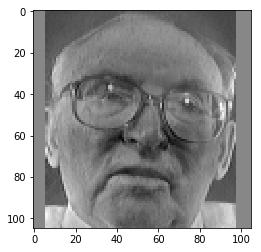

In [41]:
plt.imshow(orl.X_validation[0,0].reshape(105,105),cmap='gray')
plt.show()

In [42]:
print("orl.X.shape:{}".format(orl.X.shape))
print("orl.X_validation.shape:{}".format(orl.X_validation.shape))
batch = orl.get_training_pairs(8,2,1)

orl.X.shape:(30, 8, 105, 105, 1)
orl.X_validation.shape:(30, 2, 105, 105, 1)


In [47]:
print(len(batch))
print(len(batch[0]))
print(batch[0][0].shape)

7
3
(8, 105, 105, 1)
